This notebook shows how we can extend the 1D basis function to tD case by kron product. We will test the result 2D bases by solving projection and poisson on one element. Then we solve benchmark problems in another notebook.

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
using NLsolve
using Random
using DataFrames
using Test

### This notebook solves projection and Poisson For One element ONLY

In [2]:
default(linewidth=3)
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(30 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

In [3]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square matrix by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis1D(P, Q, Qmode)
    x, _ = gausslobatto(P)
    if Qmode == "GAUSS"
        q, w = gausslegendre(Q)
    elseif Qmode == "GLL"
        q, w = gausslobatto(Q)
    else
        error("Qmode error! Choose GAUSS or GLL Quadrature points!");
    end
    V, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / V
    D = Dp / V
    x, q, w, B, D
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

function febasis2D(P, Q, num_comp, Qmode)
    # coordinate, quadrature, and basis on reference element [-1,1]
    x1_ref, q1_ref, w1_ref, B1, D1 = febasis1D(P, Q, Qmode)
    
    x, y = meshgrid(x1_ref, x1_ref)
    x2_ref = [x;y]
    qx, qy = meshgrid(q1_ref, q1_ref)
    q2_ref = [qx;qy]
    w2_ref = kron(w1_ref, w1_ref)
    
    B2 = kron(I(num_comp),kron(B1,B1))
    Dx = kron(B1, D1)
    Dy = kron(D1, B1)
    # Grad for num_comp = 1
    Dx = kron([1, 0], Dx)
    Dy = kron([0, 1], Dy)
    D2 = Dx + Dy
    D2 = kron(I(num_comp),D2)
    
    x2_ref, q2_ref, w2_ref, B2, D2
end

febasis2D (generic function with 1 method)

# What is the correct ordering of the kron product to create 2D tensor basis?

We know that for $P=2$ in 1D we have two nodal bases
$$
B1 = \begin{bmatrix} (1-x)/2 & (1+x)/2 \end{bmatrix}
$$
and 4-nodes quad element in 2D, the nodal basis is (tensor ordering NOT counter clockwise)
$$
B2 = \begin{bmatrix} (1-x)(1-y)/4 & (1+x)(1-y)/4 & (1-x)(1+y)/4 & (1+x)(1+y)/4\end{bmatrix}
$$

How we can get B2 (2D nodal basis) by kron product? 

As shown in the following $kron(B1(y), B1(x))$ gives the correct basis as above. 

The derivative of nodal basis (gradient of B2) in 2D is 
$$
D2 = \begin{bmatrix} 
-(1-y)/4 & (1-y)/4 & -(1+y)/4 & (1+y)/4 \\
-(1-x)/4 & -(1+x)/4 & (1-x)/4 & (1+x)/4
\end{bmatrix}
$$

which can be created by kron product 
$$
Dx = kron(B1(y), D1(x)) \\
Dy = kron(D1(y), B1(x))
$$
which should gives the nodal basis derivative


For $P=3$ in 1D, the nodal basis is
$$
B1 = \begin{bmatrix} x(x-1)/2 & 1-x^2 & x(1+x)/2 \end{bmatrix}
$$

In [4]:
using Symbolics
@variables x y
# This is kron(B1(x), B1(y)) for P=2 which doesn't return correct basis
kron([(1-x)/2 (1+x)/2],[(1-y)/2 (1+y)/2])

1×4 Matrix{Num}:
 (1//4)*(1 - x)*(1 - y)  (1//4)*(1 + y)*(1 - x)  …  (1//4)*(1 + x)*(1 + y)

In [5]:
# This is B2 = kron(B1(y), B1(x)) for P=2 and it's correct
kron([(1-y)/2 (1+y)/2],[(1-x)/2 (1+x)/2])

1×4 Matrix{Num}:
 (1//4)*(1 - x)*(1 - y)  (1//4)*(1 + x)*(1 - y)  …  (1//4)*(1 + x)*(1 + y)

In [6]:
# This is Dx = kron(B1(y), D1(x)) for P=2
Dx = kron([(1-y)/2 (1+y)/2],[-1/2 1/2])
# This is Dy = kron(D1(y), B1(x)) for P=2
Dy = kron([-1/2 1/2],[(1-x)/2 (1+x)/2])
Dx = kron([1, 0], Dx)
Dy = kron([0, 1], Dy)
# created D2 by kron product as given above in the discreption
D2 = Dx + Dy

2×4 Matrix{Num}:
 -0.25(1 - y)   0.25(1 - y)  -0.25(1 + y)  0.25(1 + y)
 -0.25(1 - x)  -0.25(1 + x)   0.25(1 - x)  0.25(1 + x)

In [7]:
# This is B2 = kron(B1(y), B1(x)) for P=3 and it's same as given in the text book
kron([y*(y-1)/2 1-y^2 y*(1+y)/2],[x*(x-1)/2 1-x^2 x*(1+x)/2])'

9×1 adjoint(::Matrix{Num}) with eltype Num:
   (1//4)*x*y*(x - 1)*(y - 1)
 (1//2)*y*(y - 1)*(1 - (x^2))
   (1//4)*x*y*(1 + x)*(y - 1)
 (1//2)*x*(x - 1)*(1 - (y^2))
      (1 - (x^2))*(1 - (y^2))
 (1//2)*x*(1 + x)*(1 - (y^2))
   (1//4)*x*y*(x - 1)*(1 + y)
 (1//2)*y*(1 + y)*(1 - (x^2))
   (1//4)*x*y*(1 + x)*(1 + y)

# Test B, D with classic approach
Beside above analytical approach, we test B2, D2 at quadrature points as well with basis function available in text books

In [8]:
function clasic_basis(x,y, P, num_comp)
   
    m = length(x)
    if P == 2
        B1 = @. 0.25*(1-x)*(1-y)
        B2 = @. 0.25*(1+x)*(1-y)
        B3 = @. 0.25*(1-x)*(1+y)
        B4 = @. 0.25*(1+x)*(1+y)
        B = [B1 B2 B3 B4]
        
        dB1dx = @. -0.25*(1-y)
        dB2dx = @. 0.25*(1-y)
        dB3dx = @. -0.25*(1+y)
        dB4dx = @. 0.25*(1+y)
    
        dB1dy = @. -0.25*(1-x)
        dB2dy = @. -0.25*(1+x)
        dB3dy = @. 0.25*(1-x)
        dB4dy = @. 0.25*(1+x)
    
        Dx = [dB1dx dB2dx dB3dx dB4dx]
        Dy = [dB1dy dB2dy dB3dy dB4dy]
        
    elseif P == 3

        B1 = @. x*y*(x-1)*(y-1)/4;
        B2 = @. y*(1-x^2)*(y-1)/2;       
        B3 = @. x*y*(x+1)*(y-1)/4;
        B4 = @. x*(x-1)*(1-y^2)/2;
        B5 = @. (1-x^2)*(1-y^2);
        B6 = @. x*(x+1)*(1-y^2)/2;
        B7 = @. x*y*(x-1)*(y+1)/4;
        B8 = @. y*(1-x^2)*(y+1)/2;  
        B9 = @. x*y*(x+1)*(y+1)/4;
        B = [B1 B2 B3 B4 B5 B6 B7 B8 B9]
        
        dB1dx = @. (y*x*(y-1.0))/4.0 + (y*(y-1.0)*(x-1.0))/4.0
        dB2dx = @. -y*x*(y-1.0)
        dB3dx = @. (y*x*(y-1.0))/4.0+(y*(y-1.0)*(x+1.0))/4.0
        dB4dx = @. (y.^2-1.0)*(x-1.0)*(-1.0/2.0)-(x*(y.^2-1.0))/2.0
        dB5dx = @. x*(y.^2-1.0)*2.0
        dB6dx = @. (y.^2-1.0)*(x+1.0)*(-1.0/2.0)-(x*(y.^2-1.0))/2.0
        dB7dx = @. (y*x*(y+1.0))/4.0+(y*(y+1.0)*(x-1.0))/4.0
        dB8dx = @. -y*x*(y+1.0)
        dB9dx = @. (y*x*(y+1.0))/4.0+(y*(y+1.0)*(x+1.0))/4.0
    
        dB1dy = @. (y*x*(x-1.0))/4.0+(x*(y-1.0)*(x-1.0))/4.0
        dB2dy = @. (x.^2-1.0)*(y-1.0)*(-1.0/2.0)-(y*(x.^2-1.0))/2.0
        dB3dy = @. (y*x*(x+1.0))/4.0+(x*(y-1.0)*(x+1.0))/4.0
        dB4dy = @. -y*x*(x-1.0)
        dB5dy = @. y*(x.^2-1.0)*2.0
        dB6dy = @. -y*x*(x+1.0)
        dB7dy = @. (y*x*(x-1.0))/4.0+(x*(y+1.0)*(x-1.0))/4.0
        dB8dy = @. (x.^2-1.0)*(y+1.0)*(-1.0/2.0)-(y*(x.^2-1.0))/2.0
        dB9dy = @. (y*x*(x+1.0))/4.0+(x*(y+1.0)*(x+1.0))/4.0
        
        Dx = [dB1dx dB2dx dB3dx dB4dx dB5dx dB6dx dB7dx dB8dx dB9dx]
        Dy = [dB1dy dB2dy dB3dy dB4dy dB5dy dB6dy dB7dy dB8dy dB9dy]
    
    end
    B = kron(I(num_comp), B)
    D = [Dx; Dy]
    D = kron(I(num_comp), D)
    
    return B, D
    
end

clasic_basis (generic function with 1 method)

In [9]:
P, Q, num_comp, Qmode = 3,4,2,"GAUSS"
x2_ref, q2_ref, w2_ref, B2, D2 = febasis2D(P, Q, num_comp, "GAUSS");

qx = reshape(q2_ref, Q^2,:);
B, D = clasic_basis(qx[:,1],qx[:,2], P, num_comp);

@test B ≈ B2
@test D ≈ D2

Test Passed
  Expression: D ≈ D2
   Evaluated: [-1.0907411787271268 1.380136328084323 … 0.0 0.0; -0.6731154740227354 0.54488491867554 … 0.0 0.0; … ; 0.0 0.0 … 1.2038064990248545 0.310045178123093; 0.0 0.0 … 0.351777857082634 1.0907411787271268] ≈ [-1.0907411787271268 1.380136328084323 … 0.0 0.0; -0.6731154740227354 0.54488491867554 … 0.0 0.0; … ; 0.0 0.0 … 1.2038064990248547 0.31004517812309296; 0.0 0.0 … 0.3517778570826339 1.0907411787271268]

# Galerkin method: $L^2$ projection on ref element $[-1,1]^2$

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [10]:
function L2_galerkin2d(P, Q, num_comp, Qmode, f)
    x2_ref, q2_ref, w2_ref, B2, _ = febasis2D(P, Q, num_comp, Qmode);
    W2 = diagm(w2_ref);
    if num_comp == 2
       W2 = diagm([w2_ref; w2_ref])
    end
    A = B2' * W2 * B2  # v^T * u
    q = reshape(q2_ref, Q^2,:)
    rhs = B2' * W2 * f(q[:,1], q[:,2])  # v^T * f
    # Jacobi-preconditioned mass matrix
    #@show cond(A)
    #@show cond(diagm(1 ./diag(A))*A)
    #u = (diagm(1 ./diag(A))*A) \ (diagm(1 ./diag(A))*rhs)
    u = A \ rhs

    x2_ref, u
end

L2_galerkin2d (generic function with 1 method)

In [11]:
P, Q, num_comp = 2, 2, 1
Qmode = "GAUSS"
f(x, y) = @. tanh(5*x)*tanh(y)
x, u = L2_galerkin2d(P, Q, num_comp, Qmode, f)
x = reshape(x, P^2,:)
norm(u - f(x[:,1], x[:,2]))

1.5820047883348756

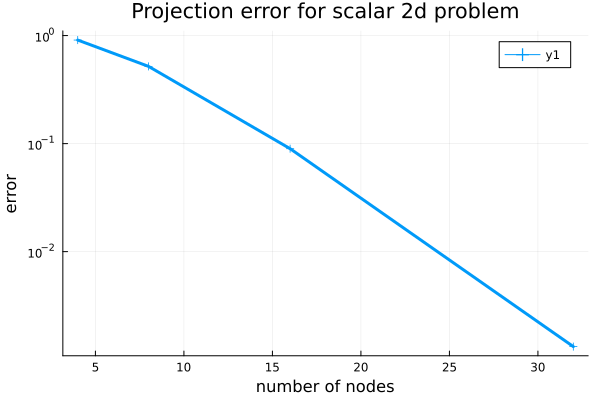

In [12]:
ns = 2 .^ (2:5)
function L2_error_proj(n, num_comp, Qmode)
    x, u = L2_galerkin2d(n, n, num_comp, Qmode, f)
    x = reshape(x, n^2,:)
    norm(u - f(x[:,1], x[:,2]))
end
plot(ns, L2_error_proj.(ns, num_comp, Qmode), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")
title!("Projection error for scalar 2d problem")

In [13]:
function f(x, y)
    vx = @. tanh(5*x)*tanh(y)
    vy = @. tanh(x)*tanh(2*y) 
    
    v = [vx; vy]
    return v
end

P, Q, num_comp = 2, 2, 2
Qmode = "GAUSS"
x, u = L2_galerkin2d(P, Q, num_comp, Qmode, f)
x = reshape(x, P^2,:)
norm(u - f(x[:,1], x[:,2]))

1.921984048534769

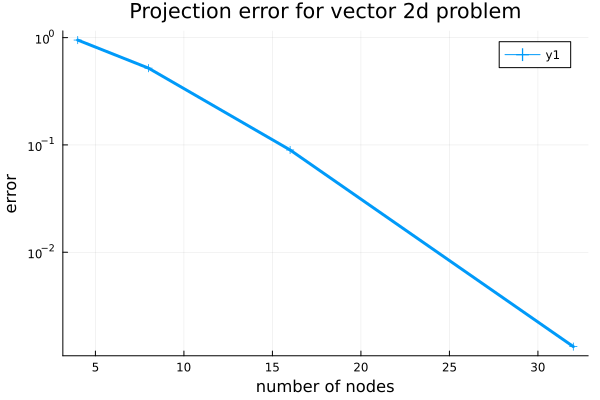

In [14]:
ns = 2 .^ (2:5)
function L2_error_proj(n, num_comp, Qmode)
    x, u = L2_galerkin2d(n, n, num_comp, Qmode, f)
    x = reshape(x, n^2,:)
    norm(u - f(x[:,1], x[:,2]))
end
plot(ns, L2_error_proj.(ns, num_comp, Qmode), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")
title!("Projection error for vector 2d problem")

# Test Grad on Ref element $[-1,1]^2$

In [15]:
# scalar case
eval1(x, y) = @. sin(x) + cos(x*y) + x*y

function eval1_grad(x, y)
    gx = @. cos(x) - y*sin(x*y) + y
    gy = @. -x*sin(x*y) + x
    
    grad = [gx; gy]
    return grad
end

# vector case
eval2(x, y) = @.  [sin(x^2 * y)  + y^3 *x; x^5*y^2 + cos(x*y)]

function eval2_grad(x, y)
    g1x = @. 2*x*y*cos(x^2*y) + y^3
    g1y = @. x^2*cos(x^2*y) + 3*y^2*x
    g2x = @. 5*x^4*y^2 - y*sin(x*y)
    g2y = @. 2*y*x^5 - x*sin(x*y)

    v = [g1x; g1y; g2x; g2y]
    return v
end

eval2_grad (generic function with 1 method)

In [16]:
P, Q, num_comp_x, num_comp_u = 2, 20, 2, 1
x2_ref, q2_L, w2_ref, BL, _ = febasis2D(P, Q, num_comp_x, "GLL");
x2_ref, q2_G, w2_ref, Bx, Dx = febasis2D(P, Q, num_comp_x, "GAUSS");
x2_ref, q2_ref, w2_ref, _, Du = febasis2D(Q, Q, num_comp_u, "GAUSS");

X = [-1, 1, -1, 1, -1, -1, 1, 1];
X_N = BL*X  # map X to Lobatto pts, so we can compute nodal values
X_N = reshape(X_N, Q^2,:)

X_q = Bx * X # map X to Gauss pts
X_q = reshape(X_q, Q^2,:);

if num_comp_u == 1
    U = eval1(X_N[:,1], X_N[:,2]) # compute U at the nodal points
    Gq_e = eval1_grad(X_q[:,1], X_q[:,2]); # Compute analytical grad at quad pts
elseif num_comp_u == 2
    U = eval2(X_N[:,1], X_N[:,2]) # compute U at the nodal
    Gq_e = eval2_grad(X_q[:,1], X_q[:,2]); # Compute analytical grad at quad pts
else
    error("num_comp_u should be 1 or 2")
end

Gq_h = Du*U; # Du is derivative at Gauss quad pts, so this should give grad at quad pts

# test grad
@test Gq_h ≈ Gq_e

Test Passed
  Expression: Gq_h ≈ Gq_e
   Evaluated: [0.3812048370891259, 0.3891823452186662, 0.40046512359434533, 0.4100941480315246, 0.4115924648653157, 0.39776395638777107, 0.3617222896598582, 0.2980364496513927, 0.20379502817660705, 0.07935048005845954  …  0.07071605115639257, 0.1766943795917073, 0.23817171855490482, 0.26265278869461994, 0.26046149230373494, 0.24242635484007025, 0.21801200872361903, 0.19428628933818004, 0.17576315497075257, 0.16486675224163605] ≈ [0.3812048370891322, 0.3891823452186681, 0.4004651235943456, 0.4100941480315232, 0.4115924648653162, 0.39776395638777373, 0.36172228965985864, 0.2980364496513922, 0.20379502817660744, 0.07935048005846002  …  0.0707160511563814, 0.17669437959170864, 0.23817171855491154, 0.26265278869459896, 0.2604614923037354, 0.24242635484003017, 0.21801200872359217, 0.19428628933816117, 0.1757631549707669, 0.16486675224160596]

# Test Grad on element $[0,1]^2$
First we need the Jacobian

### Test J and invJ; See Rich's FE note and Wriggers Eq 4.10
Base on eq 4.10 the $\nabla u = \frac{\partial u}{\partial x}= J^{-T} \frac{\partial u}{\partial \xi}$ where

$$
J = \begin{bmatrix} 
\frac{\partial x}{\partial \xi} & \frac{\partial x}{\partial \eta} \\
\frac{\partial y}{\partial \xi} & \frac{\partial y}{\partial \eta}
\end{bmatrix}
$$

In [17]:
# Clasic definition of J
function BilinearMap(Coord_E, X, Y)

    B1 = @. 0.25*(1-X)*(1-Y)
    B2 = @. 0.25*(1+X)*(1-Y)
    B3 = @. 0.25*(1-X)*(1+Y)
    B4 = @. 0.25*(1+X)*(1+Y)
    B = [B1 B2 B3 B4]
        
    dB1dX = @. -0.25*(1-Y)
    dB2dX = @. 0.25*(1-Y)
    dB3dX = @. -0.25*(1+Y)
    dB4dX = @. 0.25*(1+Y)
    
    dB1dY = @. -0.25*(1-X)
    dB2dY = @. -0.25*(1+X)
    dB3dY = @. 0.25*(1-X)
    dB4dY = @. 0.25*(1+X)
    
    DX = [dB1dX dB2dX dB3dX dB4dX]
    DY = [dB1dY dB2dY dB3dY dB4dY]
    
    # quadrature pts in physical coordinate
    x = B * Coord_E[1:4]
    y = B * Coord_E[5:end]
    qx = [x y]

    dxdX = DX * Coord_E[1:4]
    dydX = DX * Coord_E[5:end]
    
    dxdY = DY * Coord_E[1:4]
    dydY = DY * Coord_E[5:end]
    # standard definition of J = dx/dX = [dxdX dxdY; dydX dydY] = dx_i/dX_j
    J = [dxdX dxdY dydX dydY]
    
    return qx, J
end


P, Q, num_comp = 2, 4, 2
x2_ref, q2_ref, w2_ref, B, D = febasis2D(P, Q, num_comp, "GAUSS");

qx = reshape(q2_ref, Q^2,:);

Coord_E = [0, 1, 0, 1, 0, 0, 1, 1.5];
# Coord_E = [0, 1, 0, 1, 0, 0, 1, 1];
# classic definition of J
_, J = BilinearMap(Coord_E, qx[:,1], qx[:,2]);

# Using D which is created by tensor product
J1 = D*Coord_E
J2 = reshape(J1, Q^2, :)
# Check clasic J and J2 which created by D
@test J ≈ J2

Test Passed
  Expression: J ≈ J2
   Evaluated: [0.5 0.0 0.01735796105074343 0.5173579610507434; 0.5 0.0 0.01735796105074343 0.5825023695518929; … ; 0.5 0.0 0.2326420389492566 0.6674976304481071; 0.5 0.0 0.2326420389492566 0.7326420389492566] ≈ [0.5 0.0 0.01735796105074343 0.5173579610507434; 0.5 0.0 0.01735796105074343 0.5825023695518929; … ; 0.5 0.0 0.2326420389492566 0.6674976304481071; 0.5 0.0 0.2326420389492566 0.7326420389492566]

In [18]:
# Check invJ
J3 = zeros(Q^2, 2, 2)
detJ = zeros(Q^2)
invJ_T = zeros(Q^2, 2, 2)
for i=1:Q^2
    J3[i,:,:] = reshape(J2[i,:], 2, 2) # this reshape here transposes J = dx/dX to ==> [dxdX dydX; dxdY dydY] 
    detJ[i] = det(J3[i,:,:])
    invJ_T[i,:,:] = I/J3[i,:,:] # So actually this is J^{-T}
end
# see how reshape change the ordering
a=[1 2 3 4]
reshape(a, 2, 2)

2×2 Matrix{Int64}:
 1  3
 2  4

First we test that the J2 is the same as standard J, but when we reshape it and define J3, the reshape function gives the transpose of the standard definition of J (see printed `J3[1,:,:]` and compare it with the 1st row of J).
In fact, `I/J3[i,:,:]` in the code above is equal to standard $J^{-T}$

In [19]:
J3[1,:,:] # because of reshape this is transpose of the given J below

2×2 Matrix{Float64}:
 0.5  0.017358
 0.0  0.517358

In [20]:
J[1,:] #[dxdX dxdY dydX dydY]

4-element Vector{Float64}:
 0.5
 0.0
 0.01735796105074343
 0.5173579610507434

### Now we are ready to test grad on [0,1]^2

In [21]:
P, Q, num_comp_x, num_comp_u = 2, 20, 2, 1
x2_ref, q2_L, w2_ref, BL, _ = febasis2D(P, Q, num_comp_x, "GLL");
x2_ref, q2_G, w2_ref, Bx, Dx = febasis2D(P, Q, num_comp_x, "GAUSS");
x2_ref, q2_ref, w2_ref, _, Du = febasis2D(Q, Q, num_comp_u, "GAUSS");

#X = [0, 1, 0, 1, 0, 0, 1, 1];
X = [0, 1.25, 0, 1, 0, 0, 1, 1];
X_N = BL*X  # map X to Lobatto pts (nodal pts)
X_N = reshape(X_N, Q^2,:)

X_q = Bx * X # map X to Gauss pts
X_q = reshape(X_q, Q^2,:);


J1 = Dx*X
J2 = reshape(J1, Q^2, :)
J = zeros(Q^2, 2, 2)
detJ = zeros(Q^2)
invJ_T = zeros(Q^2, 2, 2)
for i=1:Q^2
    J[i,:,:] = reshape(J2[i,:], 2, 2) # this is J^T
    detJ[i] = det(J[i,:,:])
    invJ_T[i,:,:] = I/J[i,:,:]
end

Dd = zeros(2 * num_comp_u * Q^2, size(Du,2))
for c=1:num_comp_u
    for i=1:Q^2
        D1 = zeros(2, size(Du,2))
        D1[1,:] = Du[i + 2*(c-1)*Q^2,:]
        D1[2,:] = Du[i + (2*(c-1)+1)*Q^2,:]
        grad_u = invJ_T[i,:,:] * D1

        Dd[i + 2*(c-1)*Q^2,:] = grad_u[1,:]
        Dd[i + (2*(c-1)+1)*Q^2,:] = grad_u[2,:]
    end
end

if num_comp_u == 1
    U = eval1(X_N[:,1], X_N[:,2]) # compute U at the nodal
    Gq_e = eval1_grad(X_q[:,1], X_q[:,2]); # Compute analytical grad at quad pts
elseif num_comp_u == 2
    U = eval2(X_N[:,1], X_N[:,2]) # compute U at the nodal
    Gq_e = eval2_grad(X_q[:,1], X_q[:,2]); # Compute analytical grad at quad pts
else
    error("num_comp_u should be 1 or 2")
end

Gq_h = Dd*U; # Dd is derivative at Gauss quad pts on element E, so this should give grad at quad pts

# test grad for scalar function eval1; numerical is equal to analytical
@test Gq_h ≈ Gq_e

Test Passed
  Expression: Gq_h ≈ Gq_e
   Evaluated: [1.003426440527495, 1.0031822738357523, 1.0019330440817877, 0.9983903641080996, 0.9909094556655137, 0.9777091148577183, 0.9571293647029739, 0.9278967008198689, 0.8893594696335869, 0.8416549333245565  …  0.2631928355260651, 0.26127684852613164, 0.25247316572745326, 0.238782661707015, 0.2224046421947108, 0.20544224008918377, 0.18968943685356976, 0.17652296524335043, 0.16689191173338713, 0.16137216268333532] ≈ [1.0034264405274946, 1.003182273835741, 1.0019330440817953, 0.9983903641080958, 0.9909094556655184, 0.9777091148577259, 0.9571293647029736, 0.9278967008198715, 0.8893594696335873, 0.8416549333245564  …  0.2631928355260681, 0.26127684852606076, 0.25247316572739653, 0.2387826617070442, 0.2224046421947139, 0.2054422400892304, 0.18968943685354778, 0.17652296524344602, 0.16689191173340123, 0.16137216268329435]

# Galerkin method for Poisson on ref element $[-1,1]^2$

$$ \int_{\Omega} \nabla v \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [22]:
function poisson_galerkin2d(P, Q, num_comp, Qmode, f)

    x2_ref, q2_ref, w2_ref, B2, D2 = febasis2D(P, Q, num_comp, Qmode);
    WB = diagm(w2_ref);
    WD = diagm([w2_ref; w2_ref]);
    if num_comp == 2
        WB = diagm([w2_ref; w2_ref])
        WD = diagm([w2_ref; w2_ref;w2_ref; w2_ref]);
    end
    A = D2' * WD * D2  # grad(v)^T * grad(u)
    q = reshape(q2_ref, Q^2,:)
    rhs = B2' * WB * f(q[:,1], q[:,2])  # v^T * f
    # Dirichlet Boundary conditions
    bottom_face1 = 1:P
    right_face1 = P:P:P^2
    top_face1 = P^2 - P + 1:P^2
    left_face1 = 1:P:P^2 - P + 1
    
    for c=0:num_comp -1
        for i=1:P
            A[bottom_face1[i] .+ c * P^2,:] .= 0.
            A[bottom_face1[i] .+ c * P^2, bottom_face1[i] .+ c * P^2] = 1.
            rhs[bottom_face1[i] .+ c * P^2] = 0.
        
            A[top_face1[i] .+ c * P^2,:] .= 0.
            A[top_face1[i] .+ c * P^2, top_face1[i] .+ c * P^2] = 1.
            rhs[top_face1[i] .+ c * P^2] = 0.
        
            A[right_face1[i] .+ c * P^2,:] .= 0.
            A[right_face1[i] .+ c * P^2, right_face1[i] .+ c * P^2] = 1.
            rhs[right_face1[i] .+ c * P^2] = 0.
        
            A[left_face1[i] .+ c * P^2,:] .= 0.
            A[left_face1[i] .+ c * P^2, left_face1[i] .+ c * P^2] = 1.
            rhs[left_face1[i] .+ c * P^2] = 0.
        end
    end
    
    u = A \ rhs

    x2_ref, u, A, rhs
end

poisson_galerkin2d (generic function with 1 method)

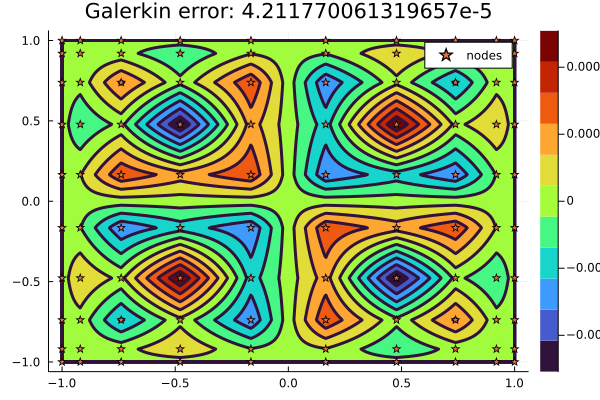

In [23]:
P, Q, num_comp = 10, 10, 1
Qmode = "GAUSS"
uex(x,y) = @. sin(pi*x)*sin(pi*y)
f(x, y) = @. 2*pi^2 * sin(pi*x)*sin(pi*y)
x, u, A, rhs = poisson_galerkin2d(P, Q, num_comp, Qmode, f)
x = reshape(x, P^2,:)
err = u - uex(x[:,1], x[:,2])
z = reshape(err, P, :)
contourf(x[1:P,1], x[1:P,1], z, color=:turbo, levels=10, title="Galerkin error: $(norm(err))")
scatter!(x[:,1], x[:,2], marker=:star, label = "nodes")

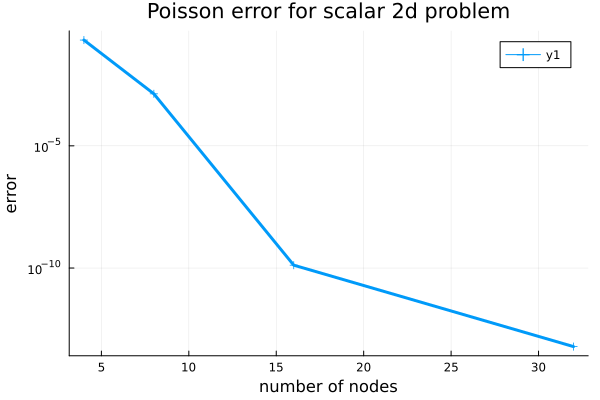

In [24]:
ns = 2 .^ (2:5)
function L2_error_poisson(n, num_comp, Qmode)
    x, u = poisson_galerkin2d(n, n, num_comp, Qmode, f)
    x = reshape(x, n^2,:)
    norm(u - uex(x[:,1], x[:,2]))
end
plot(ns, L2_error_poisson.(ns, num_comp, Qmode), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")
title!("Poisson error for scalar 2d problem")

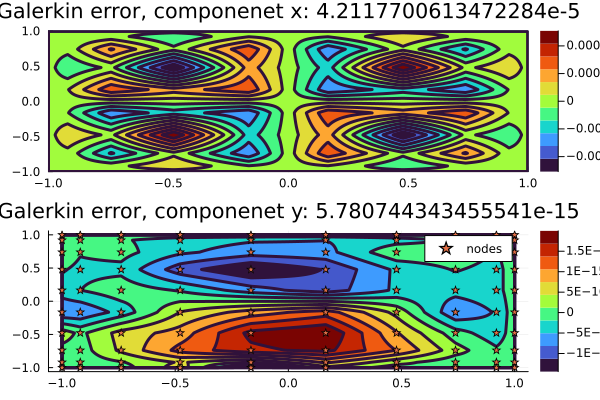

In [25]:
function uex(x, y)
    ux = @. sin(pi*x)*sin(pi*y)
    uy = @. (x^2 - 1)*(y^2 - 1) 
    return [ux; uy]
end

function f(x, y)
    fx = @. 2*pi^2 * sin(pi*x)*sin(pi*y)
    fy = @. -2*((y^2 - 1) + (x^2 - 1)) 
    return [fx; fy]
end

P, Q, num_comp = 10, 10, 2
Qmode = "GAUSS"
x, u, A, rhs = poisson_galerkin2d(P, Q, num_comp, Qmode, f)
x = reshape(x, P^2,:)
err = u - uex(x[:,1], x[:,2])
z = reshape(err, P^2, :)
p1=contourf(x[1:P,1], x[1:P,1], z[:,1], color=:turbo, levels=10, title="Galerkin error, componenet x: $(norm(z[:,1]))");
p2=contourf(x[1:P,1], x[1:P,1], z[:,2], color=:turbo, levels=10, title="Galerkin error, componenet y: $(norm(z[:,2]))");
scatter!(x[:,1], x[:,2], marker=:star, label = "nodes")
plot(p1,p2, layout=(2,1))

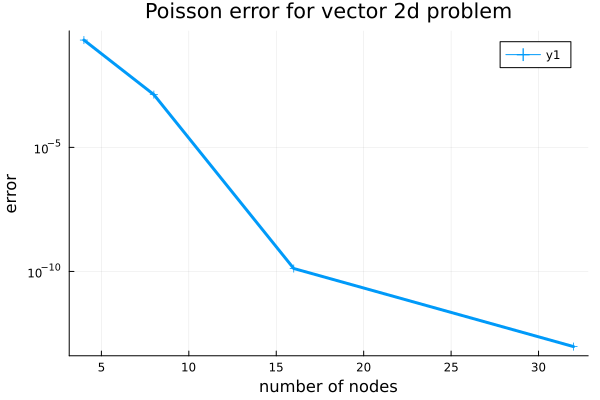

In [26]:
ns = 2 .^ (2:5)
function L2_error_poisson(n, num_comp, Qmode)
    x, u = poisson_galerkin2d(n, n, num_comp, Qmode, f)
    x = reshape(x, n^2,:)
    norm(u - uex(x[:,1], x[:,2]))
end
plot(ns, L2_error_poisson.(ns, num_comp, Qmode), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")
title!("Poisson error for vector 2d problem")

# Combine both on element E

We solve

$$
\kappa \nabla^2 u + u = f
$$

Weak form

$$
\int v \nabla u \cdot n - \int \nabla v \kappa \nabla u + \int v u = \int v f
$$

Note 
$$
\nabla v_{(d \times P)} = \frac{\partial X}{\partial x}_{(d \times Q)} \frac{\partial v}{\partial X}_{(Q \times P)}
$$

In fact we need to update each row of $D = \frac{\partial v}{\partial X}$ by jacobian.

In [27]:
function general_galerkin2d(P, Q, num_comp, Qmode, f, Coord_E)
    
    x2_ref, q2_ref, w2_ref, Bu, Du = febasis2D(P, Q, num_comp, Qmode);
    _, _, _, Bx, Dx = febasis2D(2, Q, 2, Qmode);
    _, _, _, BL, _ = febasis2D(2, Q, 2, "GLL");
    #
    J1 = Dx*Coord_E
    J2 = reshape(J1, Q^2, :)
    J = zeros(Q^2, 2, 2)
    detJ = zeros(Q^2)
    invJ_T = zeros(Q^2, 2, 2)
    for i=1:Q^2
        J[i,:,:] = reshape(J2[i,:], 2, 2)
        detJ[i] = det(J[i,:,:])
        invJ_T[i,:,:] = I/J[i,:,:]
    end
    
    # quadrature pts in elmenet E
    q = Bx * Coord_E
    wdetJ = w2_ref .* detJ;
    
    WB = diagm(wdetJ);
    WD = diagm([wdetJ; wdetJ]);
    if num_comp == 2
        WB = diagm([wdetJ; wdetJ])
        WD = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end   
    
    Dd = zeros(2 * num_comp * Q^2, size(Du,2))
    for c=1:num_comp_u
        for i=1:Q^2
            D1 = zeros(2, size(Du,2))
            D1[1,:] = Du[i + 2*(c-1)*Q^2,:]
            D1[2,:] = Du[i + (2*(c-1)+1)*Q^2,:]
            grad_u = invJ_T[i,:,:] * D1
            D2 = invJ_T[i,:,:]' * grad_u

            Dd[i + 2*(c-1)*Q^2,:] = D2[1,:]
            Dd[i + (2*(c-1)+1)*Q^2,:] = D2[2,:]
        end
    end
    
    K = Du' * WD * Dd  # grad(v)^T * kappa * grad(u)
    
    xq = reshape(q, Q^2,:)
    rhs = Bu' * WB * f(xq[:,1], xq[:,2])  # v^T * f
    
    M = Bu' * WB * Bu
    
    A = M - K
    # Dirichlet Boundary conditions
    bottom_face1 = 1:P
    right_face1 = P:P:P^2
    top_face1 = P^2 - P + 1:P^2
    left_face1 = 1:P:P^2 - P + 1
    
    for c=0:num_comp -1
        for i=1:P
            A[bottom_face1[i] .+ c * P^2,:] .= 0.
            A[bottom_face1[i] .+ c * P^2, bottom_face1[i] .+ c * P^2] = 1.
            rhs[bottom_face1[i] .+ c * P^2] = 0.
        
            A[top_face1[i] .+ c * P^2,:] .= 0.
            A[top_face1[i] .+ c * P^2, top_face1[i] .+ c * P^2] = 1.
            rhs[top_face1[i] .+ c * P^2] = 0.
        
            A[right_face1[i] .+ c * P^2,:] .= 0.
            A[right_face1[i] .+ c * P^2, right_face1[i] .+ c * P^2] = 1.
            rhs[right_face1[i] .+ c * P^2] = 0.
        
            A[left_face1[i] .+ c * P^2,:] .= 0.
            A[left_face1[i] .+ c * P^2, left_face1[i] .+ c * P^2] = 1.
            rhs[left_face1[i] .+ c * P^2] = 0.
        end
    end
    
    u = A \ rhs
    x = BL * Coord_E
    x, u
end

general_galerkin2d (generic function with 1 method)

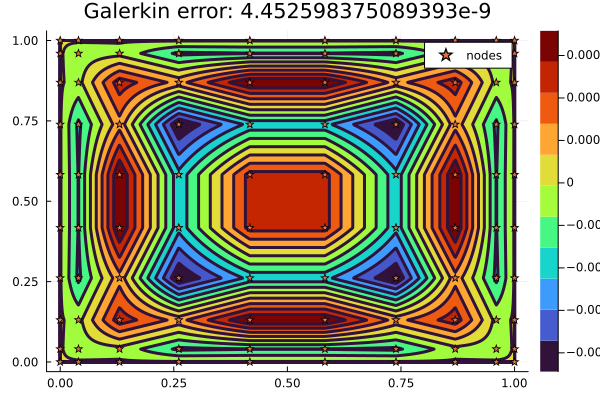

In [28]:
# uniform element E, scalar
P, Q, num_comp, Qmode = 10, 10, 1,"GAUSS" 
uex(x,y) = @. sin(pi*x)*sin(pi*y)
f(x, y) = @. (1-2*pi^2) * sin(pi*x)*sin(pi*y)
Coord_E = [0, 1, 0, 1, 0, 0, 1, 1]
x, u = general_galerkin2d(P, Q, num_comp, Qmode, f, Coord_E);
x = reshape(x, P^2,:)
err = u - uex(x[:,1], x[:,2])
z = reshape(err, P, :)
contourf(x[1:P,1], x[1:P,1], z, color=:turbo, levels=10, title="Galerkin error: $(norm(err))")
scatter!(x[:,1], x[:,2], marker=:star, label = "nodes")